In [29]:
!pip install matplotlib-venn

     ---------------------------------------- 0.0/40.8 kB ? eta -:--:--
     -------------------------------------- 40.8/40.8 kB 955.7 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotlib-venn: filename=matplotlib_venn-1.1.2-py3-none-any.whl size=45437 sha256=a9f2563babf45daca023ea1dcbb2b8bb84bf6f2db6ad67c570ec4ae18fa71587
  Stored in directory: c:\users\堀江雅彦\appdata\local\pip\cache\wheels\c4\16\4a\93374cd955bbe0553a8ce74db7f0fbd5fcc876e19fb78bd601
Successfully built matplotlib-venn



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import japanize_matplotlib
import numpy as np

import random
# ランダムに生成す値のシードを固定して再現性を担保する
def seed_everything(seed:int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
sns.set_context("talk")
seed_everything(510)

In [33]:
# --- 1. 全データの読み込み ---
INPUT_DIR = "../"

In [34]:
# 出力のディレクトリを作成
OUTPUT_DIR = "../outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [35]:
# --- 1. 全データの読み込み ---

df_train = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
df_test = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
df_position = pd.read_csv(os.path.join(INPUT_DIR, "position_history.csv"))
df_overtime = pd.read_csv(os.path.join(INPUT_DIR, "overtime_work_by_month.csv"))
df_hr = pd.read_csv(os.path.join(INPUT_DIR, "hr.csv"))
df_dx = pd.read_csv(os.path.join(INPUT_DIR, "dx.csv"))
df_udemy = pd.read_csv(os.path.join(INPUT_DIR, "udemy_activity.csv"))
df_career = pd.read_csv(os.path.join(INPUT_DIR, "career.csv"))


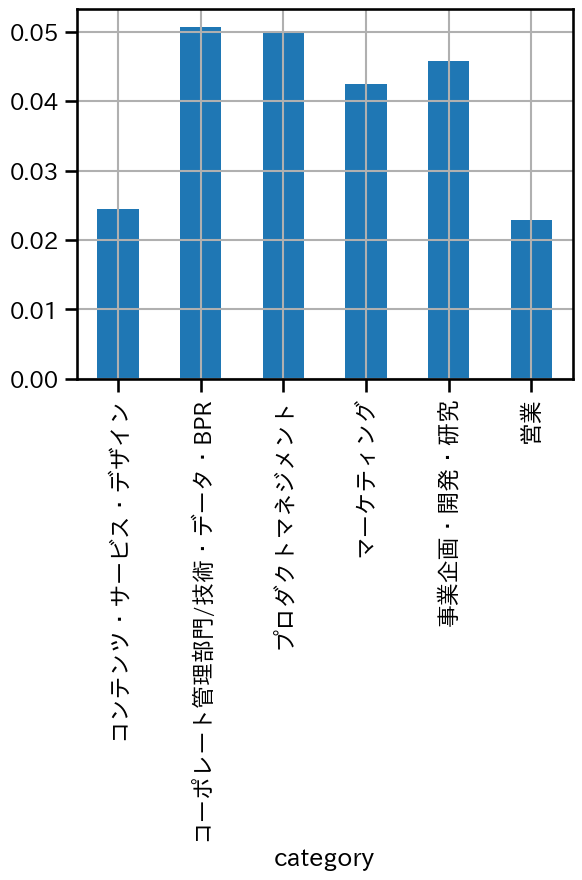

In [ ]:
# 初手の可視化は目的変数から。目的変数がどのくらいの頻度で出てきているのか
ax = df_train.groupby("category")["target"].mean().plot(kind="bar")
ax.grid()

目的変数の可視化から、ポジティブデータが全体の2～5％ととても少ないことが分かる


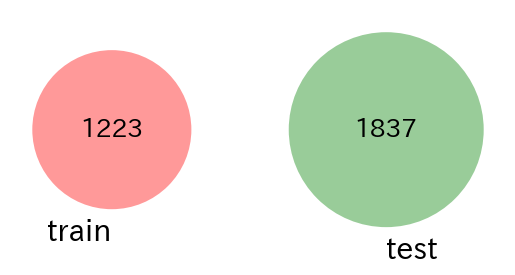

In [ ]:
# データの重なりの可視化
# trainデータとtestデータで社員に重なりが無いかを確認
venn2(subsets=(set(df_train["社員番号"].unique()), set(df_test["社員番号"].unique())), set_labels=("train", "test"))

trainデータとtestデータで社員に重なりが無いことが分かる。

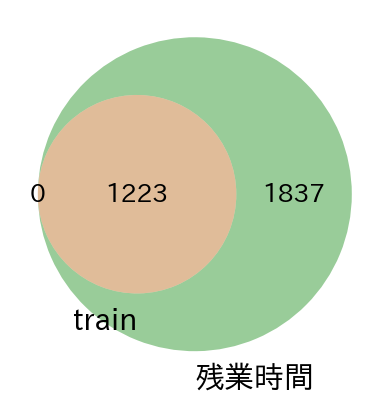

In [38]:
# 残業時間ごとに応募カテゴリの応募率はどうなっているのか？ベン図を書いてみる
venn2(subsets=(set(df_train["社員番号"].unique()), set(df_overtime["社員番号"].unique())), set_labels=("train", "残業時間"))


残業時間が無いようなtrainデータは無い。
残業時間の欠損が無いので、より機械学習に使いやすい。

他のベン図も作ってみるよー

C:\Users\堀江雅彦\AppData\Local\Temp\ipykernel_6892\626331110.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  z= df_train.groupby([hours, "category"])["target"].mean().unstack()


<Axes: xlabel='category', ylabel='社員番号'>

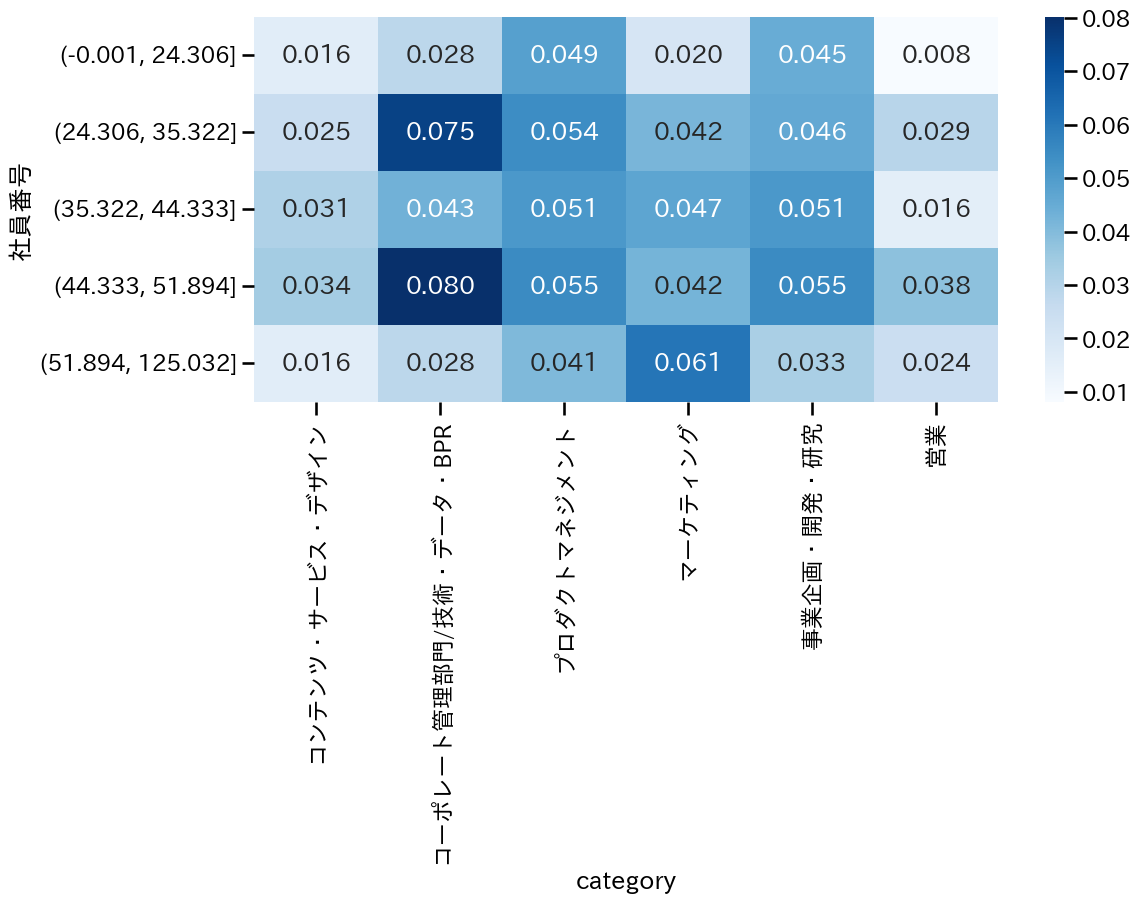

In [ ]:
# 社員ごとに平均残業時間を求める
mean_hours_by_workers = df_overtime.groupby("社員番号")["hours"].mean()

# q-cutはquantile cutの略で、連続地を書く幅が同じくらいのデータになるように区切ってくれる
mean_hours_by_workers = pd.qcut(mean_hours_by_workers, q=5)
hours =df_train["社員番号"].map(mean_hours_by_workers)

# 縦軸が1人当たりの残業時間となる
z= df_train.groupby([hours, "category"])["target"].mean().unstack()

fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(z, cmap="Blues", annot=True, fmt=".3f", ax=ax)

社員ごとの残業時間の可視化により、
・マーケティングは残業時間が増えると公募が増える
・PdMや事業企画は残業時間に関わらず。
・コンテンツや営業は真ん中にピークがある
・コーポレートは真ん中にピークがある。
中程度の残業時間を持っている人が公募に手を上げやすい

特徴量エンジニアリング：df_position


In [43]:
# 社員番号の年度の最大から最小を引くと在籍年数になる
df_position_working_years = df_position.groupby("社員番号")["year"].max() - df_position.groupby("社員番号")["year"].min()
print(df_position_working_years)

# 在籍年数をあらたな特徴量とする関数を作成
def merge_by_worker_id(left, right):
    return pd.merge(left["社員番号"], right, on="社員番号", how="left").drop(columns=["社員番号"])


社員番号
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    2
-4taxxVbT1nU-J5fHWmDfQ==    2
-5W_JQCSTAYe2gGJMuT4_w==    2
                           ..
zuplFpzBoM4c1dFy5HPXqg==    2
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    2
zxY0Eflwm1tYj1Wt6vo_1g==    2
zxmtr2h4ypvsNq02K9AMJg==    2
Name: year, Length: 3060, dtype: int64


In [ ]:
# 社員番号の役職のユニーク数を数えれば、役職が変化した人がいる
# 1ならずっと同じ役職。3なら年度ごとに全部違う役職
df_position_position_count= df_position.groupby("社員番号")["役職"].nunique()
print(df_position_position_count)

# 役職の変化を新たな特徴量として追加
# aggはagrigationで集約情報という意味
# 働いている年数とポジションを変えた年数は何回あるかを集計する関数
def create_positon_aggregation_feture(input_df):
    agg = pd.concat([
        (df_position.groupby("社員番号")["year"].max() - df_position.groupby("社員番号")["year"].min()),
        df_position.groupby("社員番号")["役職"].nunique().rename("change_positon_count")
    ], axis=1)

    return merge_by_worker_id(input_df, agg)

create_positon_aggregation_feture(df_train)

社員番号
-1sqs0GXzpPJuAVKHUUFgg==    2
-2Sq3E0WkZj8pL7jxdL3Cg==    1
-4jh26kLzkU8JFQwdeQU9w==    1
-4taxxVbT1nU-J5fHWmDfQ==    1
-5W_JQCSTAYe2gGJMuT4_w==    1
                           ..
zuplFpzBoM4c1dFy5HPXqg==    1
zwcjIiu_sqUs8akLOfuYKA==    2
zxPKKLM85QljzRfp0yisow==    1
zxY0Eflwm1tYj1Wt6vo_1g==    1
zxmtr2h4ypvsNq02K9AMJg==    1
Name: 役職, Length: 3060, dtype: int64


,year,change_positon_count
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
7333,2,1
7334,2,1
7335,2,1
7336,2,1


In [54]:
# 役職の最終年度の24年度の役職のみを取り出す（lastを使う）
# アンダーバーは一時的な変数を定義するときに付けることが多い
_df = df_position.groupby("社員番号").last()
print(_df)
def create_career_one_hot_encoding_feature(input_df):
    column_name = "役職"
    unique_values = df_position[column_name].unique()
    _df = df_position.groupby("社員番号").last()

    # 役職をカテゴリにする
    cat_series = pd.Categorical(_df[column_name], categories=unique_values)
    df_dummy = pd.get_dummies(cat_series, prefix=column_name)

    df_dummy.columns = df_dummy.columns.tolist()
    df_dummy["社員番号"] = _df.index

    return merge_by_worker_id(input_df, df_dummy)



print("---ワンホットエンコーディング実施---")
create_career_one_hot_encoding_feature(df_train)


                          year      勤務区分        役職
社員番号                                              
-1sqs0GXzpPJuAVKHUUFgg==    24       正社員  グループリーダー
-2Sq3E0WkZj8pL7jxdL3Cg==    24       正社員        一般
-4jh26kLzkU8JFQwdeQU9w==    24  正社員(管理職)        課長
-4taxxVbT1nU-J5fHWmDfQ==    24       正社員        一般
-5W_JQCSTAYe2gGJMuT4_w==    24       正社員        一般
...                        ...       ...       ...
zuplFpzBoM4c1dFy5HPXqg==    24       正社員        一般
zwcjIiu_sqUs8akLOfuYKA==    24  正社員(管理職)        部長
zxPKKLM85QljzRfp0yisow==    24       正社員        一般
zxY0Eflwm1tYj1Wt6vo_1g==    24       正社員        一般
zxmtr2h4ypvsNq02K9AMJg==    24       正社員        一般

[3060 rows x 3 columns]
---ワンホットエンコーディング実施---


,役職_一般,役職_グループリーダー,役職_課長,役職_部長,役職_副部長,役職_副本部長,役職_室長,役職_本部長,役職_支社長,役職_副室長
0,True,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
7333,True,False,False,False,False,False,False,False,False,False
7334,True,False,False,False,False,False,False,False,False,False
7335,True,False,False,False,False,False,False,False,False,False
7336,True,False,False,False,False,False,False,False,False,False


<bound method _AxesBase.grid of <Axes: >>

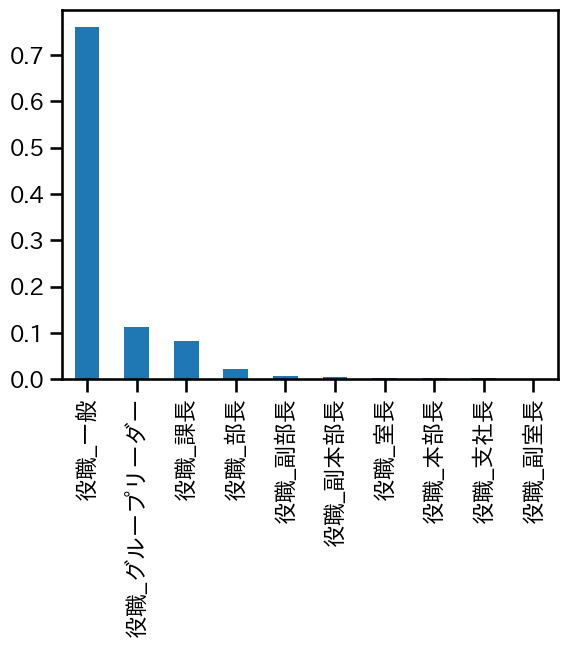

In [55]:
# ワンホットエンコーディング後の分布
ax = df_dummy.mean().plot(kind="bar")
ax.grid

In [ ]:
# 
def create_category_one_hot_encoding_feture(input_df: pd.DataFrame):
    column_name = "Category"
    unique_values = inp
    


In [11]:
# --- 2. 各データの集計・加工 ---

# 応募者データ（ターゲット）の作成
df_target = df_train.groupby('社員番号')['target'].max().reset_index()

# 最新の役職データを抽出
df_position_latest = df_position.sort_values('year').groupby('社員番号').last().reset_index()

# 残業時間の平均を算出
df_overtime_avg = df_overtime.groupby('社員番号')['hours'].mean().reset_index()
df_overtime_avg = df_overtime_avg.rename(columns={'hours': '月平均残業時間'})

# 研修(hr)の受講回数をカウント
df_hr_count = df_hr.groupby('社員番号').size().reset_index(name='研修受講回数')

# DX研修の受講回数をカウント
df_dx_count = df_dx.groupby('社員番号').size().reset_index(name='DX研修受講回数')

# Udemyのアクティビティ数をカウント
df_udemy_count = df_udemy.groupby('社員番号').size().reset_index(name='Udemyアクティビティ数')

# キャリアアンケートのデータを加工
# カラム名を短縮 (例: career_q1, career_q2...)
original_career_columns = df_career.columns.tolist()
new_career_columns = {col: f'career_q{i}' for i, col in enumerate(original_career_columns)}
df_career_processed = df_career.rename(columns=new_career_columns)
df_career_processed = df_career_processed.rename(columns={'career_q0': '社員番号'}) # 社員番号のカラム名は元に戻す

# 回答の文字列からスコア（数字）を抽出する関数
def extract_score(value):
    if isinstance(value, str):
        match = re.search(r'^(\d)', value.strip())
        if match:
            return int(match.group(1))
    return None # 数値が見つからない場合はNone（欠損値）

# 社員番号以外の全カラムに適用
for col in df_career_processed.columns:
    if col != '社員番号':
        df_career_processed[col] = df_career_processed[col].apply(extract_score)




In [12]:
# --- 3. 全データの結合（マージ） ---

# df_targetをベースに、加工したデータを次々にマージ
df_merged = pd.merge(df_target, df_position_latest[['社員番号', '勤務区分', '役職']], on='社員番号', how='left')
df_merged = pd.merge(df_merged, df_overtime_avg, on='社員番号', how='left')
df_merged = pd.merge(df_merged, df_hr_count, on='社員番号', how='left')
df_merged = pd.merge(df_merged, df_dx_count, on='社員番号', how='left')
df_merged = pd.merge(df_merged, df_udemy_count, on='社員番号', how='left')
df_merged = pd.merge(df_merged, df_career_processed, on='社員番号', how='left')


# --- 4. 最終的な統合データの確認 ---
print("✅ 全データを統合したデータフレームが完成しました。")

print("\n--- データフレーム情報 ---")
df_merged.info()

print("\n--- 統合後のデータサンプル (先頭5行) ---")
pd.set_option('display.max_columns', None)

print(df_merged.head())

✅ 全データを統合したデータフレームが完成しました。

--- データフレーム情報 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223 entries, 0 to 1222
Data columns (total 53 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   社員番号           1223 non-null   object 
 1   target         1223 non-null   int64  
 2   勤務区分           1223 non-null   object 
 3   役職             1223 non-null   object 
 4   月平均残業時間        1223 non-null   float64
 5   研修受講回数         633 non-null    float64
 6   DX研修受講回数       588 non-null    float64
 7   Udemyアクティビティ数  899 non-null    float64
 8   career_q1      163 non-null    float64
 9   career_q2      163 non-null    float64
 10  career_q3      163 non-null    float64
 11  career_q4      163 non-null    float64
 12  career_q5      163 non-null    float64
 13  career_q6      163 non-null    float64
 14  career_q7      163 non-null    float64
 15  career_q8      163 non-null    float64
 16  career_q9      163 non-null    float64
 17  career